In [47]:
import numpy as np
np.random.seed(42)

import random
random.seed(42)

In [48]:
import pandas
import numpy as np

ratings_df = pandas.read_csv('ratings.csv')

userIDs = ratings_df['userId'].values
movies = ratings_df['movieId'].values
ratings = ratings_df['rating'].values



#Compute using dictionary of movies/userIDs
movies_dict = {}
user_dict = {}
for i in range(len(userIDs)):
    
    #Use movieID as key
    if (movies[i] not in movies_dict.keys()):
        movies_dict[movies[i]] = [(userIDs[i], ratings[i])]
    else:
        movies_dict[movies[i]].append((userIDs[i], ratings[i]))
        
    #Use userID as key
    if (userIDs[i] not in user_dict.keys()):
        user_dict[userIDs[i]] = [(movies[i], ratings[i])]
    else:
        user_dict[userIDs[i]].append((movies[i], ratings[i]))

num_ratings = 0
for movieID in movies_dict.keys():
    for item in movies_dict[movieID]:
        num_ratings += 1

sparsity_dict = num_ratings/(len(movies_dict.keys()) * len(user_dict.keys()))

#print("Sparsity is: {}".format(sparsity))
print("Sparsity (dict) is: {}".format(sparsity_dict))

Sparsity (dict) is: 0.016999683055613623


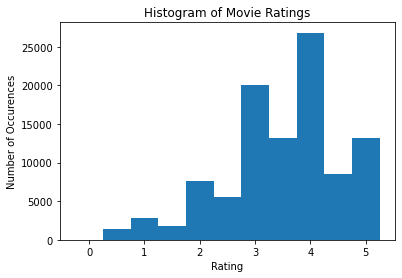

In [49]:
#Q2

import matplotlib.pyplot as plt

#Bars are centered around the ratings (0.5, 1, 1.5, etc.)
hist_bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
plt.hist(ratings, bins=hist_bins)
plt.xlabel("Rating")
plt.title("Histogram of Movie Ratings")
plt.ylabel("Number of Occurences")
plt.show()

#Looks normally distributed, mean around 3.5-4. Most reviewed movies were enjoyed by the viewer
#Nobody gave a review of 0/5

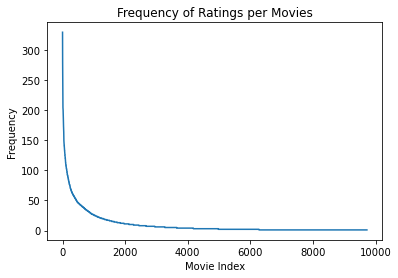

In [50]:
#Q3

freqs = []
for movie in movies_dict.keys():
    freqs.append(len(movies_dict[movie]))

freqs = np.sort(np.asarray(freqs))
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("Movie Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per Movies")
plt.show()    

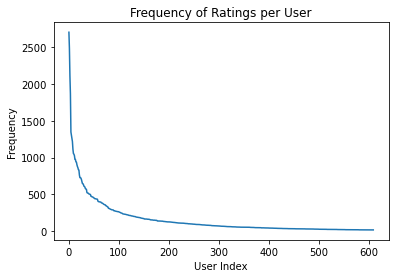

In [51]:
#Q4

freqs = []
for movie in user_dict.keys():
    freqs.append(len(user_dict[movie]))

freqs = np.sort(np.asarray(freqs))
movie_ind = np.flip(np.arange(freqs.shape[0]))
plt.plot(movie_ind,freqs)
plt.xlabel("User Index")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings per User")
plt.show()

Q5

Recommendations will be heavily weighted towards a few hundred movies, since those are the most reviewed ones. Most movies have less than 25 reviews, so our matrix will be sparse.

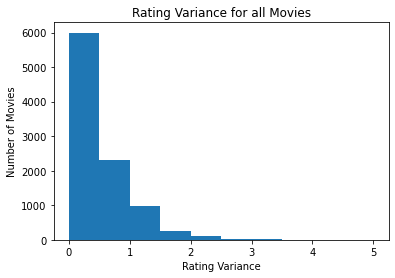

In [52]:
#Q6
#Variances are low for most movies (0-1). This suggests that most users seem to agree on which movies are good/bad
hist_bins = np.arange(0, 5.5, 0.5)
variances = []
for movie in movies_dict.keys():
    temp_vars = []
    for item in movies_dict[movie]:
        temp_vars.append(item[1])
    variances.append(np.var(np.asarray(temp_vars)))
    
plt.hist(variances, bins=hist_bins)
plt.xlabel("Rating Variance")
plt.title("Rating Variance for all Movies")
plt.ylabel("Number of Movies")
plt.show()        

Q7

$\mu_u = \frac{\sum_{k \in{I_u}}r_{uk}}{length(I_u)}$

Q8

$I_u \cap I_v$ represents the set of indices for the movies rated by both users u and v. This can be equal to $\emptyset$, meaning that they haven't seen any of the same movies. Given that our rating matrix is very sparse, this is likely to be the case if we were to randomly select any two users.

Q9

This mean-centering process helps reduce the influence of outliers, and reduce bias in our predictions. This would remove the effect of users that only give high/low ratings of movies, since the low variance of their rankings suggests that their opinions on movies are biased and may not be suitable for movie recommendations. 

Working with k = 10
Working with k = 20
Working with k = 30
Working with k = 40
Working with k = 50
Working with k = 60
Working with k = 70
Working with k = 80
Working with k = 90
Working with k = 100


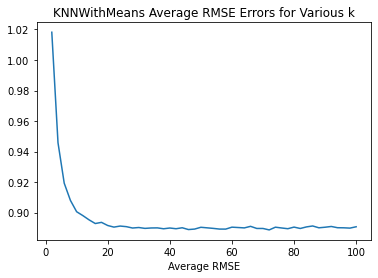

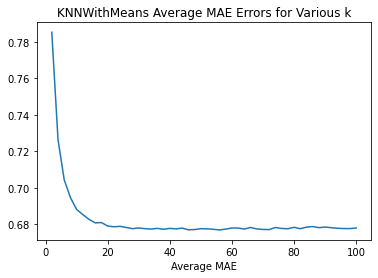

In [53]:
#Q10

from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.similarities import pearson
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import KFold

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)

sim_options = {'name': 'pearson',
               'user_based': True
               }

reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 102, 2)
num_splits = 10
kf = KFold(n_splits=num_splits)

#Unnecessarilly large number of k values - could stop at 50 and get the same result
for k in k_vals:
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
    curr_knn = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    cv_result = cross_validate(curr_knn, ratings_df_sup, cv=kf, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

plt.plot(k_vals, rmse_vals)
plt.title("KNNWithMeans Average RMSE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, mae_vals)
plt.title("KNNWithMeans Average MAE Errors for Various k")
plt.xlabel("k")
plt.xlabel("Average MAE")
plt.show()


In [54]:
#Q11

#We can see that our minimum k for both is around 20. The steady state averages for both are as follows:

rmse_min_k = 20
mae_min_k = 20
print("Steady state average RMSE error = {}".format(np.average(rmse_vals[rmse_min_k//2 - 1:])))
print("Steady state average MAE error = {}".format(np.average(mae_vals[mae_min_k//2 - 1:])))

Steady state average RMSE error = 0.8900070917977092
Steady state average MAE error = 0.6777676834256994


In [55]:
#Make trimming dictionaries and functions


#Make dictionary for entire dataset
ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

mov_dict = {}
for elem in ratings_df_sup.raw_ratings:
    
    if (elem[1] not in mov_dict.keys()):
        mov_dict[elem[1]] = [elem]
    else:
        mov_dict[elem[1]].append(elem)


def trim_pop(arr):
    ret_arr = []
    for elem in arr:
        if (len(mov_dict[elem[1]]) > 2):
            ret_arr.append(elem)
    return ret_arr

def trim_unpop(arr):
    ret_arr = []
    for elem in arr:
        if (len(mov_dict[elem[1]]) <= 2):
            ret_arr.append(elem)
    return ret_arr

def trim_var(arr):
    ret_arr = []
    for elem in arr:
        if (len(mov_dict[elem[1]]) >= 5):
            rating_arr = []
            for item in mov_dict[elem[1]]:
                rating_arr.append(item[2])
            if (np.var(np.asarray(rating_arr)) >= 2):
                ret_arr.append(elem)
    return ret_arr


Working with k = 10
Working with k = 20
Working with k = 30
Working with k = 40
Working with k = 50
Working with k = 60
Working with k = 70
Working with k = 80
Working with k = 90
Working with k = 100


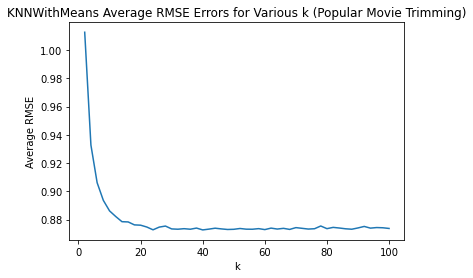

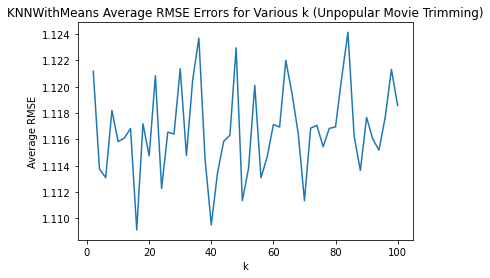

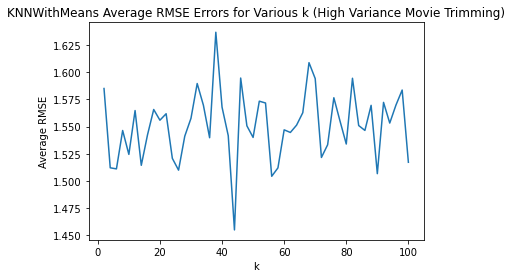

In [60]:
#Q12-14

from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans


num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 102, 2)
rmse_vals_12 = []
rmse_vals_13 = []
rmse_vals_14 = []

for k in k_vals:
    
    if (k % 10 == 0):
        print("Working with k = {}".format(k))
        
    algo = KNNWithMeans(k, sim_options=sim_options, verbose=False)
    temp_rmse_12 = 0
    temp_rmse_13 = 0
    temp_rmse_14 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)        
        
        #Q12
        predictions = algo.test(trim_pop(testset))
        temp_rmse_12 += accuracy.rmse(predictions, verbose=False)

        #Q13
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_13 += accuracy.rmse(predictions, verbose=False)
        
        #Q14
        predictions = algo.test(trim_var(testset))
        temp_rmse_14 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_12.append(temp_rmse_12/num_splits)
    rmse_vals_13.append(temp_rmse_13/num_splits)
    rmse_vals_14.append(temp_rmse_14/num_splits)


plt.plot(k_vals, rmse_vals_12)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.plot(k_vals, rmse_vals_13)
plt.title("KNNWithMeans Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure;
plt.plot(k_vals, rmse_vals_14)
plt.title("KNNWithMeans Average RMSE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

In [61]:
#No steady-state minimum, just minimum 

print("Minimum RMSE error for Popular Trimming = {}".format(min(rmse_vals_12)))
print("Minimum RMSE error for Unpopular Trimming = {}".format(min(rmse_vals_13)))
print("Minimum RMSE error for High Variance Trimming = {}".format(min(rmse_vals_14)))


Minimum RMSE error for Popular Trimming = 0.872712660867539
Minimum RMSE error for Unpopular Trimming = 1.1091243151137091
Minimum RMSE error for High Variance Trimming = 1.4548055994701596


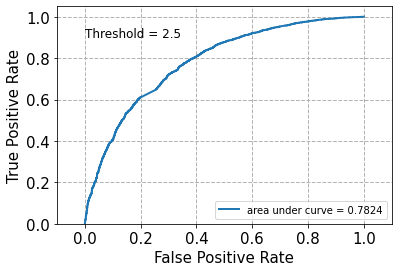

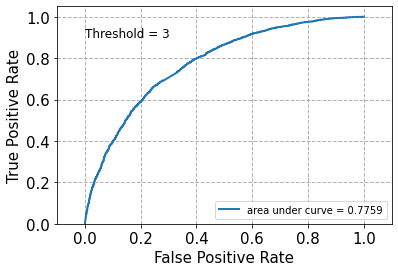

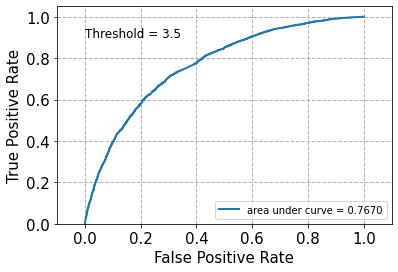

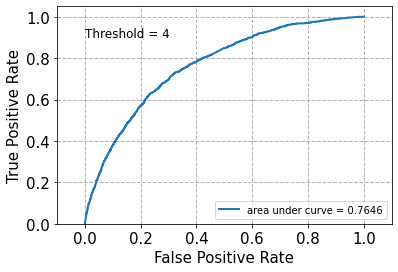

In [62]:
#Q15
from surprise.model_selection import train_test_split
from sklearn import metrics

def plot_roc(fpr, tpr):
    #helper function taken from discussion notebook
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

threshold_values = [2.5,3,3.5,4]

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for i in threshold_values:

    trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=42)
    
    curr_knn = KNNWithMeans(k=20, sim_options=sim_options, verbose=False)
    curr_knn.fit(trainset)
    predictions = curr_knn.test(testset)
    
    preds_list = [elem[3] for elem in predictions]
    
    #need 1D list to match preds_list
    true_list = []
    for j in range(len(testset)):
        elem = 0 if testset[j][2] <= i else 1
        true_list.append(elem)

     
    fpr, tpr, thresholds = metrics.roc_curve(true_list, preds_list)
    plot_roc(fpr,tpr)
    plt.text(0.0,0.9,"Threshold = {}".format(i),fontsize='large')

Q16

Just equation 5 but with the V removed from the minimization problem. This is already a least squares problem. Don't think it's a convex function, but not sure why.

Working with k = 4
Working with k = 8
Working with k = 12
Working with k = 16
Working with k = 20
Working with k = 24
Working with k = 28
Working with k = 32
Working with k = 36
Working with k = 40
Working with k = 44
Working with k = 48


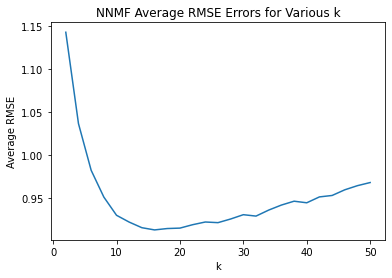

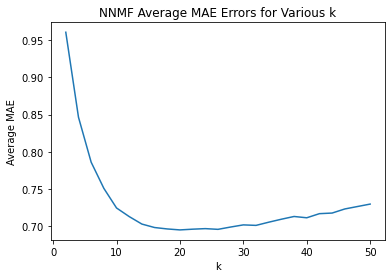

In [79]:
#Q17

from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import KFold

rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 52, 2)
num_splits = 10
kf = KFold(n_splits=num_splits)

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
    curr_nnmf = NMF(n_factors = k, random_state=42)
    cv_result = cross_validate(curr_nnmf, ratings_df_sup, cv=kf, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

    

plt.plot(k_vals, rmse_vals)
plt.title("NNMF Average RMSE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, mae_vals)
plt.title("NNMF Average MAE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average MAE")
plt.show()


In [80]:
#Q18

#From README, there are 19 genre (including "(no genres listed)" being a genre).
print("NNMF Minimum Average RMSE error = {}".format(min(rmse_vals)))
print("NNMF k for Mimimum Average RMSE error = {}".format((np.argmin(rmse_vals) + 1)*2))

print("NNMF Minimum Average MAE Error = {}".format(min(mae_vals)))
print("NNMF k for Minimum Average MAE error = {}".format((np.argmin(mae_vals) + 1)*2))     

NNMF Minimum Average RMSE error = 0.9131618316335771
NNMF k for Mimimum Average RMSE error = 16
NNMF Minimum Average MAE Error = 0.6948488925385634
NNMF k for Minimum Average MAE error = 20


Working with k = 4
Working with k = 8
Working with k = 12
Working with k = 16
Working with k = 20
Working with k = 24
Working with k = 28
Working with k = 32
Working with k = 36
Working with k = 40
Working with k = 44
Working with k = 48


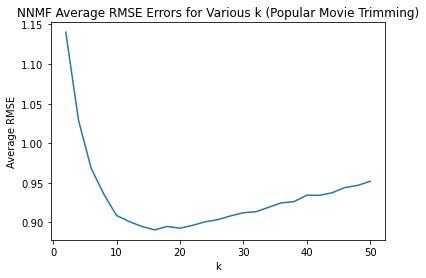

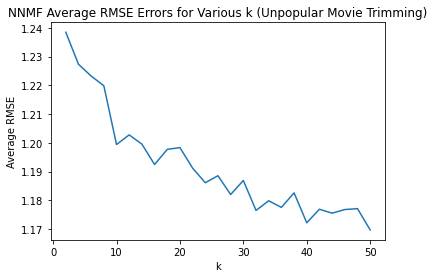

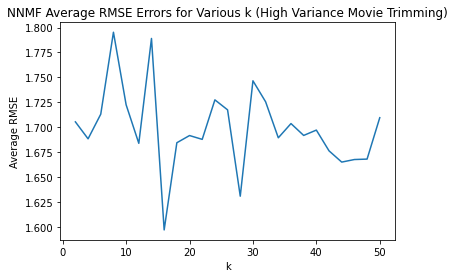

In [65]:
#Q19-21

from surprise import accuracy
from surprise.model_selection import KFold

num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 52, 2)
rmse_vals_19 = []
rmse_vals_20 = []
rmse_vals_21 = []

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
        
    algo = NMF(n_factors=k, random_state=42)
    temp_rmse_19 = 0
    temp_rmse_20 = 0
    temp_rmse_21 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)
        
        
        #Q19
        predictions = algo.test(trim_pop(testset))
        temp_rmse_19 += accuracy.rmse(predictions, verbose=False)

        #Q20
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_20 += accuracy.rmse(predictions, verbose=False)
        
        #Q21
        predictions = algo.test(trim_var(testset))
        temp_rmse_21 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_19.append(temp_rmse_19/num_splits)
    rmse_vals_20.append(temp_rmse_20/num_splits)
    rmse_vals_21.append(temp_rmse_21/num_splits)


plt.plot(k_vals, rmse_vals_19)
plt.title("NNMF Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, rmse_vals_20)
plt.title("NNMF Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, rmse_vals_21)
plt.title("NNMF Average RMSE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

In [66]:
#Q19-21
print("NNMF Minimum RMSE error for Popular Trimming = {}".format(min(rmse_vals_19)))
print("NNMF Minimum RMSE error for Unpopular Trimming = {}".format(min(rmse_vals_20)))
print("NNMF Minimum RMSE error for High Variance Trimming = {}".format(min(rmse_vals_21)))


NNMF Minimum RMSE error for Popular Trimming = 0.8906223281951136
NNMF Minimum RMSE error for Unpopular Trimming = 1.1697338876980428
NNMF Minimum RMSE error for High Variance Trimming = 1.5971734037426255


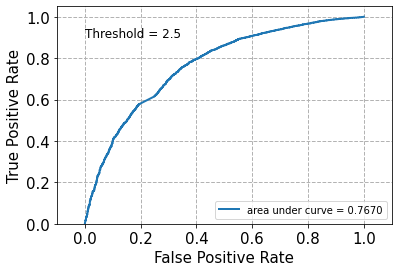

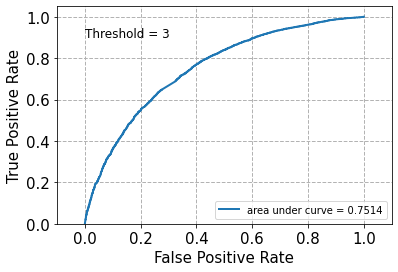

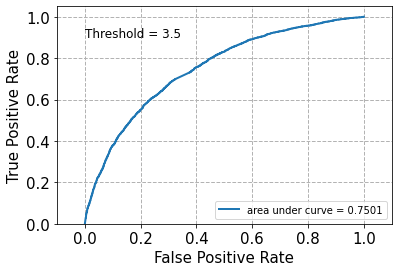

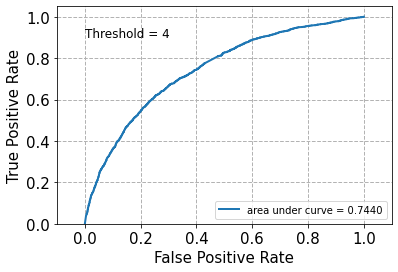

In [67]:
#Q22
#best k = 16 for RMSE and k = 20 for MAE. Pick one of the two
from surprise.model_selection import train_test_split
from sklearn import metrics

nnmf_best_k = 20
def plot_roc(fpr, tpr):
    #helper function taken from discussion notebook
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

threshold_values = [2.5,3,3.5,4]
ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for i in threshold_values:
    trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=42)
    
    curr_algo = NMF(n_factors=nnmf_best_k, random_state=42)
    curr_algo.fit(trainset)
    predictions = curr_algo.test(testset)
    
    preds_list = [elem[3] for elem in predictions]
    
    #need 1D list to match preds_list
    true_list = []
    for j in range(len(testset)):
        elem = 0 if testset[j][2] <= i else 1
        true_list.append(elem)

     
    fpr, tpr, thresholds = metrics.roc_curve(true_list, preds_list)
    plot_roc(fpr,tpr)
    plt.text(0.0,0.9,"Threshold = {}".format(i),fontsize='large')

In [68]:
#Q23

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

movies_df_pd = pandas.read_csv('movies.csv')
userIDs_mov = movies_df_pd['title'].values
movies_mov = movies_df_pd['movieId'].values
genres_mov = movies_df_pd['genres'].values

trainset = ratings_df_sup.build_full_trainset()
algo_23 = NMF(n_factors=20, random_state=42)
algo_23.fit(trainset)

#Might be flipped. double check needed
U = algo_23.pu
V = algo_23.qi

import copy
movies_df_pd = pandas.read_csv('movies.csv',index_col ="movieId")
    
col0_sort = np.sort(copy.deepcopy(V[:,0]))
top10_0 = np.flip(col0_sort[-10:])
movies = []
for i in top10_0:
    loc = int(np.where(V[:,0] == i)[0])
    movies.append(trainset.to_raw_iid(loc))
print()
print("col 0:")
for mov in movies:
    print(movies_df_pd.loc[mov])
    
    
col1_sort = np.sort(copy.deepcopy(V[:,1]))
top10_1 = np.flip(col1_sort[-10:])
movies = []
for i in top10_1:
    loc = int(np.where(V[:,1] == i)[0])
    movies.append(trainset.to_raw_iid(loc))
print()
print("col 1:")
for mov in movies:
    print(movies_df_pd.loc[mov])


Working with k = 4
Working with k = 8
Working with k = 12
Working with k = 16
Working with k = 20
Working with k = 24
Working with k = 28
Working with k = 32
Working with k = 36
Working with k = 40
Working with k = 44
Working with k = 48


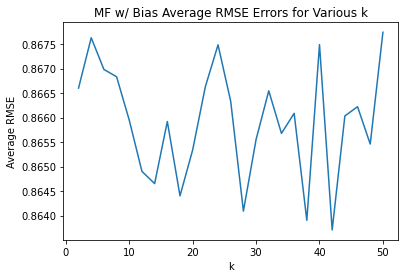

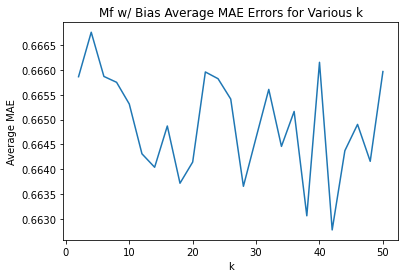

In [68]:
#Q24

from surprise.prediction_algorithms.matrix_factorization import SVD

#Use SVD
rmse_vals = []
mae_vals = []
k_vals = np.arange(2, 52, 2)
num_splits = 10
kf = KFold(n_splits=num_splits)

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
    curr_svd = SVD(n_factors = k, random_state=42)
    cv_result = cross_validate(curr_svd, ratings_df_sup, cv=kf, measures=['rmse', 'mae'])
    rmse_vals.append(np.average(cv_result['test_rmse']))
    mae_vals.append(np.average(cv_result['test_mae']))

    

plt.plot(k_vals, rmse_vals)
plt.title("MF w/ Bias Average RMSE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, mae_vals)
plt.title("Mf w/ Bias Average MAE Errors for Various k")
plt.xlabel("k")
plt.ylabel("Average MAE")
plt.show()

In [69]:
#Q25 

print("MF w/ Bias Minimum Average RMSE error = {}".format(min(rmse_vals)))
print("MF w/ Bias k for Mimimum Average RMSE error = {}".format((np.argmin(rmse_vals) + 1)*2))

print("MF w/ Bias Minimum Average MAE Error = {}".format(min(mae_vals)))
print("MF w/ Bias k for Minimum Average MAE error = {}".format((np.argmin(mae_vals) + 1)*2))    

MF w/ Bias Minimum Average RMSE error = 0.8637061587284659
MF w/ Bias k for Mimimum Average RMSE error = 42
MF w/ Bias Minimum Average MAE Error = 0.6627825937314891
MF w/ Bias k for Minimum Average MAE error = 42


Working with k = 4
Working with k = 8
Working with k = 12
Working with k = 16
Working with k = 20
Working with k = 24
Working with k = 28
Working with k = 32
Working with k = 36
Working with k = 40
Working with k = 44
Working with k = 48


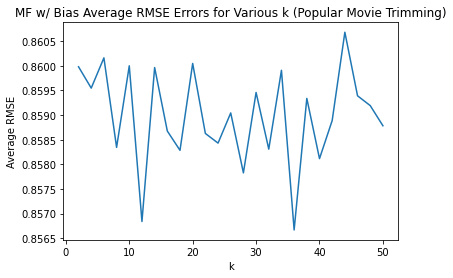

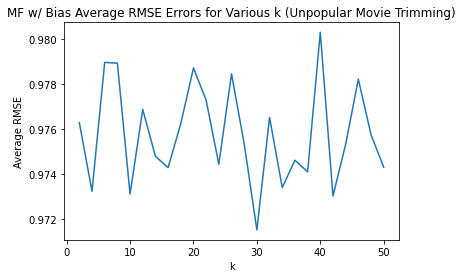

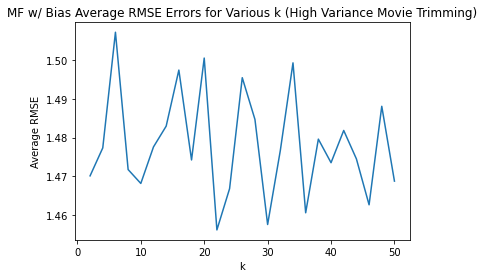

In [70]:
#Q26-28

from surprise import accuracy
from surprise.model_selection import KFold

num_splits = 10
kf = KFold(n_splits=num_splits)

k_vals = np.arange(2, 52, 2)
rmse_vals_26 = []
rmse_vals_27 = []
rmse_vals_28 = []

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for k in k_vals:
    
    if (k % 4 == 0):
        print("Working with k = {}".format(k))
        
    algo = SVD(n_factors=k, random_state=42)
    temp_rmse_26 = 0
    temp_rmse_27 = 0
    temp_rmse_28 = 0
    
    for trainset, testset in kf.split(ratings_df_sup):

        #fit training set
        algo.fit(trainset)
        
        
        #Q26
        predictions = algo.test(trim_pop(testset))
        temp_rmse_26 += accuracy.rmse(predictions, verbose=False)

        #Q27
        predictions = algo.test(trim_unpop(testset))
        temp_rmse_27 += accuracy.rmse(predictions, verbose=False)
        
        #Q28
        predictions = algo.test(trim_var(testset))
        temp_rmse_28 += accuracy.rmse(predictions, verbose=False)
    
    rmse_vals_26.append(temp_rmse_26/num_splits)
    rmse_vals_27.append(temp_rmse_27/num_splits)
    rmse_vals_28.append(temp_rmse_28/num_splits)


plt.plot(k_vals, rmse_vals_26)
plt.title("MF w/ Bias Average RMSE Errors for Various k (Popular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, rmse_vals_27)
plt.title("MF w/ Bias Average RMSE Errors for Various k (Unpopular Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

plt.figure()
plt.plot(k_vals, rmse_vals_28)
plt.title("MF w/ Bias Average RMSE Errors for Various k (High Variance Movie Trimming)")
plt.xlabel("k")
plt.ylabel("Average RMSE")
plt.show()

In [48]:
#Q26-28

print("MF w/ Bias Minimum RMSE error for Popular Trimming = {}".format(min(rmse_vals_26)))
print("MF w/ Bias Minimum RMSE error for Unpopular Trimming = {}".format(min(rmse_vals_27)))
print("MF w/ Bias Minimum RMSE error for High Variance Trimming = {}".format(min(rmse_vals_28)))

MF w/ Bias Minimum RMSE error for Popular Trimming = 0.847535921988365
MF w/ Bias Minimum RMSE error for Unpopular Trimming = 0.9002694561842809
MF w/ Bias Minimum RMSE error for High Variance Trimming = 1.3807616921288093


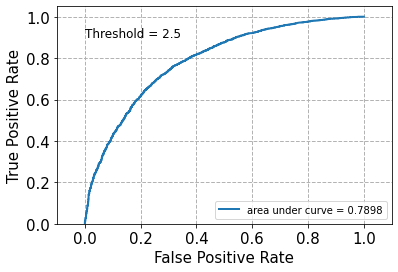

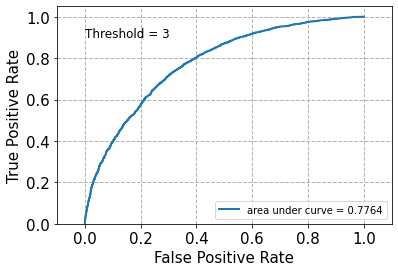

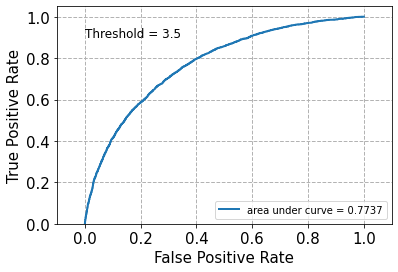

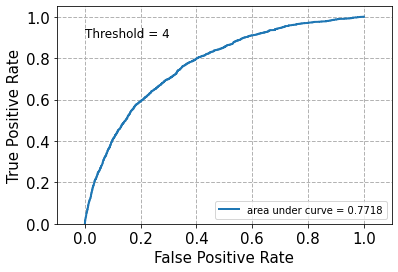

In [71]:
#Q29

#best k = 42 for RMSE and MAE. Although it doesn't really matter since the fluctuations are so low
from surprise.model_selection import train_test_split
from sklearn import metrics

mf_bias_best_k = 42
def plot_roc(fpr, tpr):
    #helper function taken from discussion notebook
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

threshold_values = [2.5,3,3.5,4]
ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

for i in threshold_values:
    trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=42)
    
    curr_algo = SVD(n_factors=mf_bias_best_k, random_state=42)
    curr_algo.fit(trainset)
    predictions = curr_algo.test(testset)
    
    preds_list = [elem[3] for elem in predictions]
    
    #need 1D list to match preds_list
    true_list = []
    for j in range(len(testset)):
        elem = 0 if testset[j][2] <= i else 1
        true_list.append(elem)

     
    fpr, tpr, thresholds = metrics.roc_curve(true_list, preds_list)
    plot_roc(fpr,tpr)
    plt.text(0.0,0.9,"Threshold = {}".format(i),fontsize='large')

In [72]:
#Q30-33

from sklearn.metrics import mean_squared_error

num_splits = 10
kf = KFold(n_splits=num_splits)

def naive_predict(test_data):
    return [ui_dict[elem[0]] for elem in test_data]

def get_true_labels(test_data):
    return [elem[2] for elem in test_data]
    
    

#Make uis, using the dictionary from Q1. This uses all data in the set
ui_dict = {}

for user in user_dict.keys():
    ui_dict[user] = np.mean([elem[1] for elem in user_dict[user]])
        
ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

rmse_30 = 0
rmse_31 = 0
rmse_32 = 0
rmse_33 = 0

for trainset, testset in kf.split(ratings_df_sup):

    #Q30
    predictions = naive_predict(testset)
    true_labels = get_true_labels(testset)
    rmse_30 += mean_squared_error(true_labels, predictions, squared=False)
    
    #Q31
    predictions = naive_predict(trim_pop(testset))
    true_labels = get_true_labels(trim_pop(testset))
    rmse_31 += mean_squared_error(true_labels, predictions, squared=False)

    #Q32
    predictions = naive_predict(trim_unpop(testset))
    true_labels = get_true_labels(trim_unpop(testset))
    rmse_32 += mean_squared_error(true_labels, predictions, squared=False)

    #Q33
    predictions = naive_predict(trim_var(testset))
    true_labels = get_true_labels(trim_var(testset))
    rmse_33 += mean_squared_error(true_labels, predictions, squared=False)

rmse_30 /= num_splits
rmse_31 /= num_splits
rmse_32 /= num_splits
rmse_33 /= num_splits

print("Naive collaborative filter Average RMSE error = {}".format(rmse_30))
print("Naive collaborative filter Average RMSE error for Popular Trimming = {}".format(rmse_31))
print("Naive collaborative filter Average RMSE error for Unpopular Trimming = {}".format(rmse_32))
print("Naive collaborative filter Average RMSE error for High Variance Trimming = {}".format(rmse_33))

Naive collaborative filter Average RMSE error = 0.9346913211136834
Naive collaborative filter Average RMSE error for Popular Trimming = 0.9323008481444051
Naive collaborative filter Average RMSE error for Unpopular Trimming = 0.9712623676719219
Naive collaborative filter Average RMSE error for High Variance Trimming = 1.4788523975501136


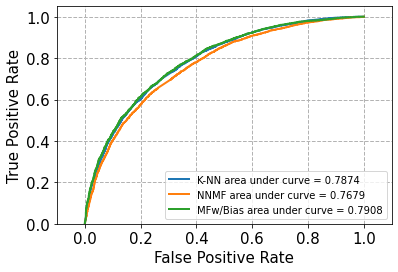

In [73]:
#Q34

ratings_df_pd = pandas.read_csv('ratings.csv')
ratings_df_sup = ratings_df_pd.drop(labels='timestamp', axis=1)
reader_df_pd = Reader(skip_lines=1, rating_scale=(0.5, 5))
ratings_df_sup = Dataset.load_from_df(ratings_df_sup, reader_df_pd)

#Get data for K-NN
trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=0)
    
curr_knn = KNNWithMeans(k=20, sim_options=sim_options, verbose=False)
curr_knn.fit(trainset)
predictions = curr_knn.test(testset)
    
#Normalize predictions between 0 and 1?
preds_list = [elem[3] for elem in predictions]
    
#need 1D list to match preds_list
true_list = []
for j in range(len(testset)):
    elem = 0 if testset[j][2] <= 3 else 1
    true_list.append(elem)

     
fpr1, tpr1, thresholds1 = metrics.roc_curve(true_list, preds_list)
roc_auc1 = metrics.auc(fpr1,tpr1)

#Get data for NNMF
trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=0)

curr_algo = NMF(n_factors=nnmf_best_k, random_state=0)
curr_algo.fit(trainset)
predictions = curr_algo.test(testset)

#Normalize predictions between 0 and 1?
preds_list = [elem[3] for elem in predictions]

#need 1D list to match preds_list
true_list = []
for j in range(len(testset)):
    elem = 0 if testset[j][2] <= 3 else 1
    true_list.append(elem)

 
fpr2, tpr2, thresholds2 = metrics.roc_curve(true_list, preds_list)
roc_auc2 = metrics.auc(fpr2,tpr2)

#Get data for MF w/ bias
trainset, testset = train_test_split(ratings_df_sup, test_size=.1, random_state=0)

curr_algo = SVD(n_factors=mf_bias_best_k, random_state=0)
curr_algo.fit(trainset)
predictions = curr_algo.test(testset)

#Normalize predictions between 0 and 1?
preds_list = [elem[3] for elem in predictions]

#need 1D list to match preds_list
true_list = []
for j in range(len(testset)):
    elem = 0 if testset[j][2] <= 3 else 1
    true_list.append(elem)

 
fpr3, tpr3, thresholds3 = metrics.roc_curve(true_list, preds_list)

roc_auc3 = metrics.auc(fpr3,tpr3)

#Plot
fig, ax = plt.subplots()

ax.plot(fpr1, tpr1, lw=2, label= 'K-NN area under curve = %0.4f' % roc_auc1)
ax.plot(fpr2, tpr2, lw=2, label= 'NNMF area under curve = %0.4f' % roc_auc2)
ax.plot(fpr3, tpr3, lw=2, label= 'MFw/Bias area under curve = %0.4f' % roc_auc3)

ax.grid(color='0.7', linestyle='--', linewidth=1)

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)

ax.legend(loc="lower right")

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontsize(15)

working on t =  2
working on t =  4
working on t =  6
working on t =  8
working on t =  10
working on t =  12
working on t =  14
working on t =  16
working on t =  18
working on t =  20
working on t =  22
working on t =  24


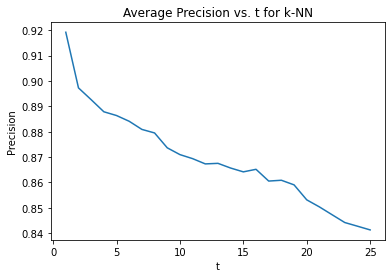

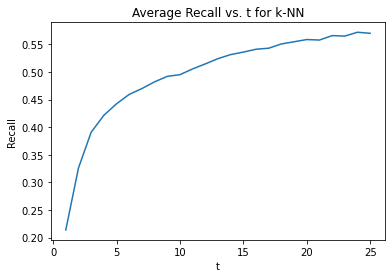

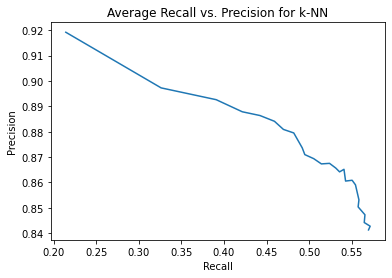

In [74]:
#Q36

from collections import defaultdict

#This function was sourced from the Surprise documentation, and modified for our purposes
def precision_recall_at_t(predictions, t=10, threshold=3.5):
    """Return precision and recall at t metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        
        #Ignore (drop) users that have rated less than t movies
        if (len(user_ratings) >= t):
            
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            #Only proceed if |G| > 0
            if (n_rel > 0):
                
                # Number of recommended items. We don't make predictions on movies that a user hasn't ranked
                # so we will never drop anything from S(t) at this point. If |S(t)| < t then we drop the user
                # since they haven't ranked enough movies, and we would never enter this loop if that's the case
                n_rec_t = t


                # Number of movies both recommended to user (and >= threshold) and that the user liked
                n_rel_and_rec_t = sum((true_r >= threshold) and (est_r >= threshold) for (est_r, true_r) in user_ratings[:t])

                precisions[uid] = n_rel_and_rec_t / n_rec_t
                recalls[uid] = n_rel_and_rec_t / n_rel

    return precisions, recalls

#10-fold cross validation - will average recall and precision
num_splits = 10
kf = KFold(n_splits=num_splits)

algo = KNNWithMeans(20, sim_options=sim_options, verbose=False)

t_precs_KNN = []
t_recs_KNN = []
t_vals = range(1,26)

for t in t_vals:
    
    if(t % 2 == 0):
        print("working on t = ", t)

    precs_fold = []
    recs_fold = []    
    for trainset, testset in kf.split(ratings_df_sup):
        algo.fit(trainset)

        predictions = algo.test(testset)
        precs, recs = precision_recall_at_t(predictions, t, 3)
        
        avg_prec = sum(precs.values())/len(precs)
        avg_rec = sum(recs.values())/len(recs)
        precs_fold.append(avg_prec)
        recs_fold.append(avg_rec)
    
    avg_prec_t = sum(precs_fold)/num_splits
    avg_rec_t = sum(recs_fold)/num_splits
    t_precs_KNN.append(avg_prec_t)
    t_recs_KNN.append(avg_rec_t)
    
plt.figure()
plt.plot(t_vals, t_precs_KNN)
plt.title("Average Precision vs. t for k-NN")
plt.xlabel("t")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_vals, t_recs_KNN)
plt.title("Average Recall vs. t for k-NN")
plt.xlabel("t")
plt.ylabel("Recall")
plt.show()

plt.figure()
plt.plot(t_recs_KNN, t_precs_KNN)
plt.title("Average Recall vs. Precision for k-NN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

working on t =  2
working on t =  4
working on t =  6
working on t =  8
working on t =  10
working on t =  12
working on t =  14
working on t =  16
working on t =  18
working on t =  20
working on t =  22
working on t =  24


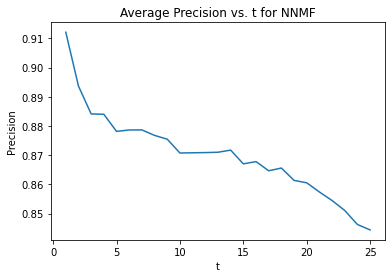

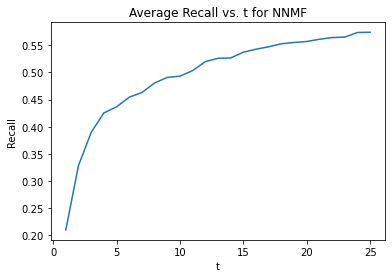

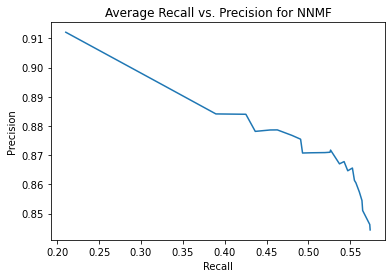

In [75]:
#Q37
#10-fold cross validation - will average recall and precision

num_splits = 10
kf = KFold(n_splits=num_splits)

algo = NMF(n_factors = nnmf_best_k, random_state=42)

t_precs_NNMF = []
t_recs_NNMF = []

for t in t_vals:
    
    if(t % 2 == 0):
        print("working on t = ", t)
    precs_fold = []
    recs_fold = []
    for trainset, testset in kf.split(ratings_df_sup):
        
        algo.fit(trainset)

        predictions = algo.test(testset)
        precs, recs = precision_recall_at_t(predictions, t, 3)
        
        avg_prec = sum(precs.values())/len(precs)
        avg_rec = sum(recs.values())/len(recs)
        precs_fold.append(avg_prec)
        recs_fold.append(avg_rec)
    
    avg_prec_t = sum(precs_fold)/num_splits
    avg_rec_t = sum(recs_fold)/num_splits
    t_precs_NNMF.append(avg_prec_t)
    t_recs_NNMF.append(avg_rec_t)
    
plt.figure()
plt.plot(t_vals, t_precs_NNMF)
plt.title("Average Precision vs. t for NNMF")
plt.xlabel("t")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_vals, t_recs_NNMF)
plt.title("Average Recall vs. t for NNMF")
plt.xlabel("t")
plt.ylabel("Recall")
plt.show()

plt.figure()
plt.plot(t_recs_NNMF, t_precs_NNMF)
plt.title("Average Recall vs. Precision for NNMF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

working on t =  2
working on t =  4
working on t =  6
working on t =  8
working on t =  10
working on t =  12
working on t =  14
working on t =  16
working on t =  18
working on t =  20
working on t =  22
working on t =  24


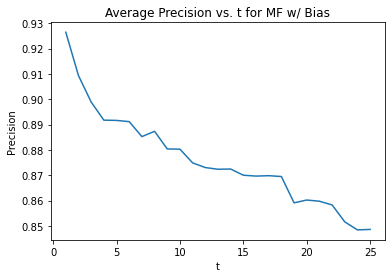

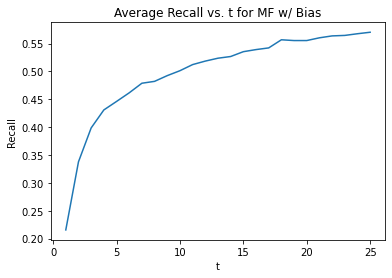

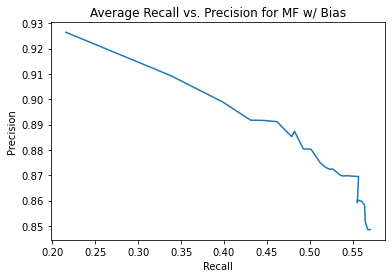

In [77]:
#Q38 
#10-fold cross validation - will average recall and precision

num_splits = 10
kf = KFold(n_splits=num_splits)

algo = SVD(n_factors=mf_bias_best_k, random_state=42)

t_precs_MF = []
t_recs_MF = []

for t in t_vals:
    
    if(t % 2 == 0):
        print("working on t = ", t)
    
    precs_fold = []
    recs_fold = []    
    for trainset, testset in kf.split(ratings_df_sup):
        
        algo.fit(trainset)

        predictions = algo.test(testset)
        precs, recs = precision_recall_at_t(predictions, t, 3)
        
        avg_prec = sum(precs.values())/len(precs)
        avg_rec = sum(recs.values())/len(recs)
        precs_fold.append(avg_prec)
        recs_fold.append(avg_rec)
    
    avg_prec_t = sum(precs_fold)/num_splits
    avg_rec_t = sum(recs_fold)/num_splits
    t_precs_MF.append(avg_prec_t)
    t_recs_MF.append(avg_rec_t)
    
plt.figure()
plt.plot(t_vals, t_precs_MF)
plt.title("Average Precision vs. t for MF w/ Bias")
plt.xlabel("t")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_vals, t_recs_MF)
plt.title("Average Recall vs. t for MF w/ Bias")
plt.xlabel("t")
plt.ylabel("Recall")
plt.show()

plt.figure()
plt.plot(t_recs_MF, t_precs_MF)
plt.title("Average Recall vs. Precision for MF w/ Bias")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

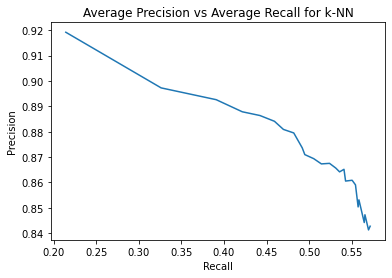

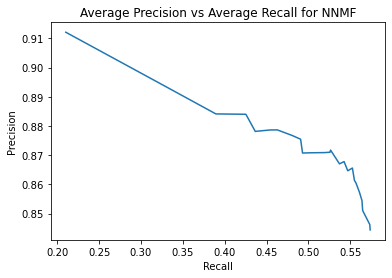

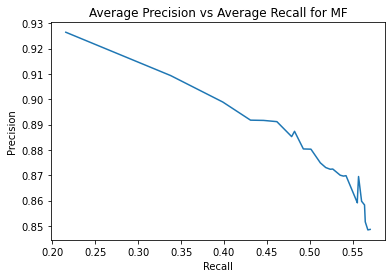

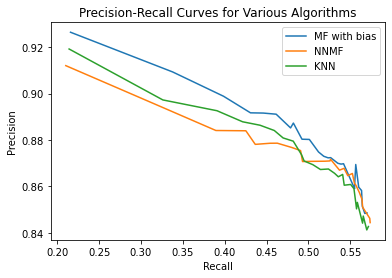

In [78]:
#Q 39 and individual recall/precision plots for 36-38
#fixing sorting so that recs are strictly increasing
t_recs_KNN, t_precs_KNN = zip(*sorted(zip(t_recs_KNN, t_precs_KNN)))
t_recs_NNMF, t_precs_NNMF = zip(*sorted(zip(t_recs_NNMF, t_precs_NNMF)))
t_recs_MF, t_precs_MF = zip(*sorted(zip(t_recs_MF, t_precs_MF)))

plt.figure()
plt.plot(t_recs_KNN, t_precs_KNN)
plt.title("Average Precision vs Average Recall for k-NN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_recs_NNMF, t_precs_NNMF)
plt.title("Average Precision vs Average Recall for NNMF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_recs_MF, t_precs_MF)
plt.title("Average Precision vs Average Recall for MF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(t_recs_MF, t_precs_MF)
plt.plot(t_recs_NNMF, t_precs_NNMF)
plt.plot(t_recs_KNN, t_precs_KNN)
plt.legend(["MF with bias", "NNMF", "KNN"])
plt.title("Precision-Recall Curves for Various Algorithms")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()